In [6]:
# Comparing RO to INS data

import sys
sys.path.append("/Users/roberto/code/robust-me-scripts/scripts")
sys.path.append("/Users/roberto/code/robust-me-scripts/scripts/config")
from figs import plot
import motion

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
import os
from numpy import *

import module
import settings

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.titlepad'] = 20
plt.rcParams.update({'font.size': 28})
plt.rcParams['axes.grid'] = True
plt.rcParams['text.usetex'] = True
# text
plt.rc("font", family=settings.FONT_FAMILY)

module.set_sys_paths()

from mrg.logging import MonolithicDecoder
from mrg.adaptors.transform import PbSerialisedTransformToPython
from mrg.transform.conversions import se3_to_components, build_se3_transform

import numpy as np
from config.data import *

color_ro = u'#d62728' #red
color_kf = u'#ff7f0e' #orange
color_kfc = u'#1f77b4' #blue
color_ero = u'#2ca02c' #green
color_ins = 'black' #black

In [210]:
dataset_path = "/Users/roberto/data/odometry-comparisons/rugged_ro/" \
               "2018-06-21-15-58-58-rural-loop-v4-radar-leopon-trial-sunny-long-range/"
# dataset_path = "/Users/roberto/data/odometry-comparisons/rugged_ro/" \
#                "2018-06-21-16-24-39-long-hanborough-to-ori-V4-radar-leopon-trial-sunny-long-range/"
INS_relative_poses_path = dataset_path+"motion_estimation/ground-truth/flattened_novatel_generated_poses.monolithic"
RO_relative_poses_path = dataset_path+"motion_estimation/standard-ro/radar_motion_estimation.monolithic"
KFC_relative_poses_path = dataset_path+"motion_estimation/untuned-kalman-with-chi-all-good-labels/radar_motion_estimation.monolithic"
# ERO_relative_poses_path = dataset_path+"motion_estimation/"\
# "untuned-kalman-with-chi-KFC-SVM-0.6thresh-median-labels-with-logging/radar_motion_estimation_v2.monolithic"
# ERO_relative_poses_path = dataset_path+"motion_estimation/untuned-kalman-with-chi-kfc-gt-labels/radar_motion_estimation.monolithic"
ERO_relative_poses_path = dataset_path+"motion_estimation/untuned-kfc-svm-live-no-thresh/2800-3600_partial_run_handcrafted_thresh0.6.monolithic"

# KFC_relative_poses_path = RO_relative_poses_path
# ERO_relative_poses_path = RO_relative_poses_path

# INS - open monolithic and iterate frames
print("reading INS_relative_poses_path: " + INS_relative_poses_path)
monolithic_decoder = MonolithicDecoder(
    INS_relative_poses_path)

# iterate mono
INS_se3s = []
INS_timestamps = []
for pb_serialised_transform, _, _ in monolithic_decoder:
    # adapt
    serialised_transform = PbSerialisedTransformToPython(
        pb_serialised_transform)
    INS_se3s.append(serialised_transform[0])
    INS_timestamps.append(serialised_transform[1])
    
# RO - open monolithic and iterate frames
print("reading RO_relative_poses_path: " + RO_relative_poses_path)
monolithic_decoder = MonolithicDecoder(
    RO_relative_poses_path)

# iterate mono
RO_se3s = []
RO_timestamps = []
for pb_serialised_transform, _, _ in monolithic_decoder:
    # adapt
    serialised_transform = PbSerialisedTransformToPython(
        pb_serialised_transform)
    RO_se3s.append(serialised_transform[0])
    RO_timestamps.append(serialised_transform[1])
    
# KFC - open monolithic and iterate frames
print("reading KFC_relative_poses_path: " + KFC_relative_poses_path)
monolithic_decoder = MonolithicDecoder(
    KFC_relative_poses_path)
# iterate mono
KFC_se3s = []
KFC_timestamps = []
for pb_serialised_transform, _, _ in monolithic_decoder:
    # adapt
    serialised_transform = PbSerialisedTransformToPython(
        pb_serialised_transform)
    KFC_se3s.append(serialised_transform[0])
    KFC_timestamps.append(serialised_transform[1])
    
    
# ERO - open monolithic and iterate frames
print("reading ERO_relative_poses_path: " + ERO_relative_poses_path)
monolithic_decoder = MonolithicDecoder(
    ERO_relative_poses_path)
# iterate mono
ERO_se3s = []
ERO_timestamps = []
for pb_serialised_transform, _, _ in monolithic_decoder:
    # adapt
    serialised_transform = PbSerialisedTransformToPython(
        pb_serialised_transform)
    ERO_se3s.append(serialised_transform[0])
    ERO_timestamps.append(serialised_transform[1])

reading INS_relative_poses_path: /Users/roberto/data/odometry-comparisons/rugged_ro/2018-06-21-15-58-58-rural-loop-v4-radar-leopon-trial-sunny-long-range/motion_estimation/ground-truth/flattened_novatel_generated_poses.monolithic
importing  protobuf.transform.pbSerialisedTransform_pb2
reading RO_relative_poses_path: /Users/roberto/data/odometry-comparisons/rugged_ro/2018-06-21-15-58-58-rural-loop-v4-radar-leopon-trial-sunny-long-range/motion_estimation/standard-ro/radar_motion_estimation.monolithic
importing  protobuf.transform.pbSerialisedTransform_pb2
reading KFC_relative_poses_path: /Users/roberto/data/odometry-comparisons/rugged_ro/2018-06-21-15-58-58-rural-loop-v4-radar-leopon-trial-sunny-long-range/motion_estimation/untuned-kalman-with-chi-all-good-labels/radar_motion_estimation.monolithic
importing  protobuf.transform.pbSerialisedTransform_pb2
reading ERO_relative_poses_path: /Users/roberto/data/odometry-comparisons/rugged_ro/2018-06-21-15-58-58-rural-loop-v4-radar-leopon-trial-

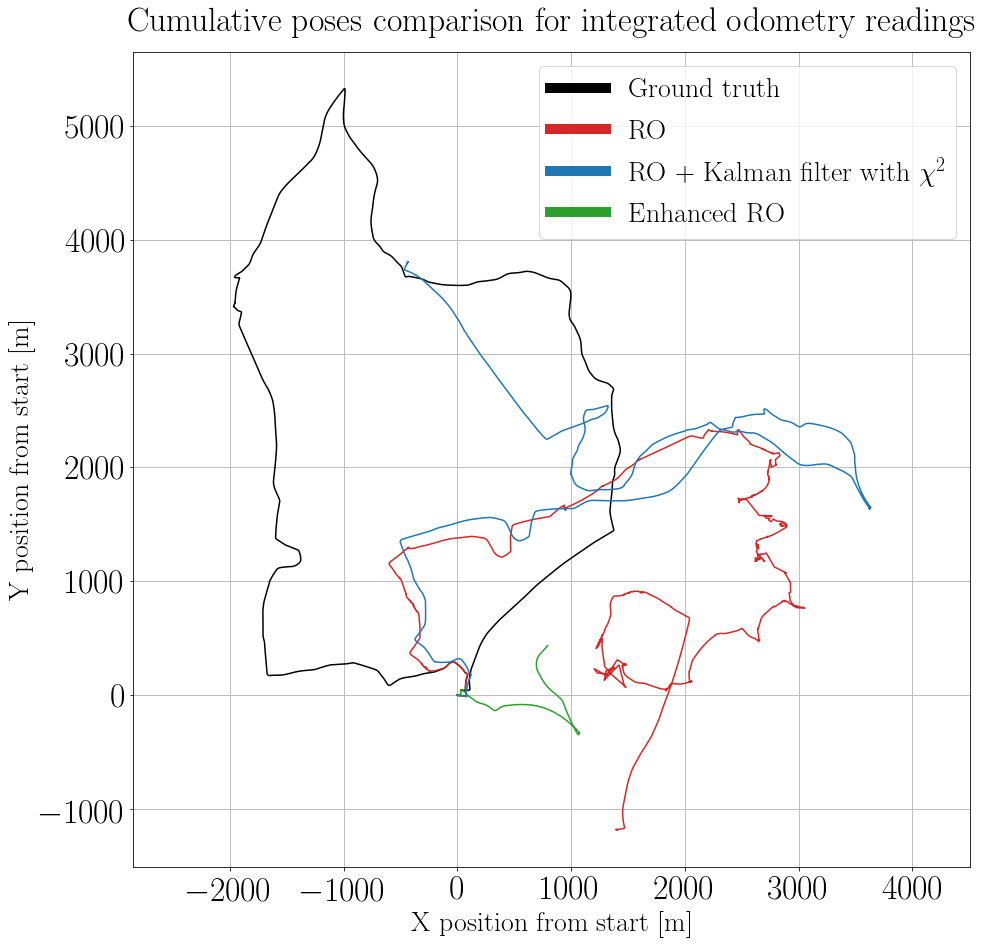

In [211]:
# get INS poses
INS_poses = []
pose = np.identity(4)
for i in range(len(INS_se3s)):
    pose = pose * INS_se3s[i]
    INS_poses.append(pose)

# get x,y coords
x_INS = [pose[0, 3] for pose in INS_poses]
y_INS = [pose[1, 3] for pose in INS_poses]
# downsample INS for figure rendering
x_INS_lite = x_INS[::10]
y_INS_lite = y_INS[::10]

# get RO poses
RO_poses = []
pose = np.identity(4)
for i in range(len(RO_se3s)):
    pose = pose * RO_se3s[i]
    RO_poses.append(pose)

# get x,y coords
x_RO = [pose[0, 3] for pose in RO_poses]
y_RO = [pose[1, 3] for pose in RO_poses]

# get KFC poses
KFC_poses = []
pose = np.identity(4)
for i in range(len(KFC_se3s)):
    pose = pose * KFC_se3s[i]
    KFC_poses.append(pose)

# get x,y coords
x_KFC = [pose[0, 3] for pose in KFC_poses]
y_KFC = [pose[1, 3] for pose in KFC_poses]

# get ERO poses
ERO_poses = []
pose = np.identity(4)
for i in range(len(ERO_se3s)):
    pose = pose * ERO_se3s[i]
    ERO_poses.append(pose)

# get x,y coords
x_ERO = [pose[0, 3] for pose in ERO_poses]
y_ERO = [pose[1, 3] for pose in ERO_poses]

plt.figure(figsize=(15,15))
plt.plot(x_INS_lite,y_INS_lite,'k-',markersize=1);
plt.plot(x_RO,y_RO,'-',color=color_ro,markersize=1);
plt.plot(x_KFC,y_KFC,'-',color=color_kfc,markersize=1);
plt.plot(x_ERO,y_ERO,'-',color=color_ero,markersize=1);
plt.axis('equal');
plt.title('Cumulative poses comparison for integrated odometry readings');
plt.xlabel('X position from start [m]');
plt.ylabel('Y position from start [m]');
line1, = plt.plot([],[],color=color_ins,label='Ground truth',linewidth=10.0)
line2, = plt.plot([],[],color=color_ro,label='RO',linewidth=10.0)
line4, = plt.plot([],[],color=color_kfc,label='RO + Kalman filter with $\chi^2$',linewidth=10.0)
line5, = plt.plot([],[],color=color_ero,label='Enhanced RO',linewidth=10.0)

plt.legend(handles=[line1,line2,line4,line5],loc='best')
plt.savefig(dataset_path+"figs/filename_all_4_poses.pdf",bbox_inches='tight',pad_inches = 0)

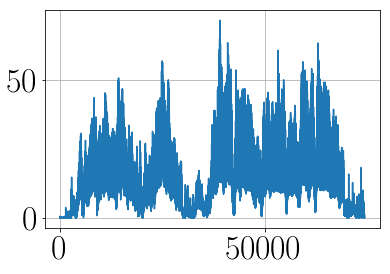

In [183]:
# get INS speeds
assert len(INS_se3s) == len(INS_timestamps)
INS_speeds = []
INS_TIMESTAMPS = []
deltatime_arr = []
for i in range(len(INS_timestamps) - 1):
# for i in range(0,len(timestamps) - 1,10): # this fixed the glitches by skipping them
# for i in range(1000,2000):
    # work out speed
    delta_time = INS_timestamps[i + 1] / settings.TIMESTAMP_CONVERSION \
        - INS_timestamps[i] / settings.TIMESTAMP_CONVERSION
    deltatime_arr.append(delta_time)
    se3 = INS_se3s[i]
    translation = se3[0:2, -1]
    incremental_distance = np.linalg.norm(translation)
    speed = incremental_distance / delta_time
    INS_speeds.append(speed)
    INS_TIMESTAMPS.append(INS_timestamps[i])
plt.plot(INS_speeds);

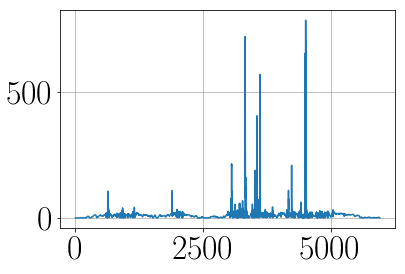

In [184]:
# get speeds
assert len(RO_se3s) == len(RO_timestamps)
RO_speeds = []
RO_TIMESTAMPS = []
deltatime_arr = []
for i in range(len(RO_timestamps) - 1):
# for i in range(0,len(timestamps) - 1,10): # this fixed the glitches by skipping them
# for i in range(1000,2000):
    # work out speed
    delta_time = RO_timestamps[i + 1] / settings.TIMESTAMP_CONVERSION \
        - RO_timestamps[i] / settings.TIMESTAMP_CONVERSION
    deltatime_arr.append(delta_time)
    se3 = RO_se3s[i]
    translation = se3[0:2, -1]
    incremental_distance = np.linalg.norm(translation)
    speed = incremental_distance / delta_time
    RO_speeds.append(speed)
    RO_TIMESTAMPS.append(RO_timestamps[i])
plt.plot(RO_speeds);

In [212]:
# get speeds

assert len(KFC_se3s) == len(KFC_timestamps)
KFC_speeds = []
KFC_TIMESTAMPS = []
deltatime_arr = []
for i in range(len(KFC_timestamps) - 1):
    # work out speed
    delta_time = KFC_timestamps[i + 1] / settings.TIMESTAMP_CONVERSION \
        - KFC_timestamps[i] / settings.TIMESTAMP_CONVERSION
    deltatime_arr.append(delta_time)
    se3 = KFC_se3s[i]
    translation = se3[0:2, -1]
    incremental_distance = np.linalg.norm(translation)
    speed = incremental_distance / delta_time
    KFC_speeds.append(speed)
    KFC_TIMESTAMPS.append(KFC_timestamps[i])

assert len(ERO_se3s) == len(ERO_timestamps)
ERO_speeds = []
ERO_TIMESTAMPS = []
deltatime_arr = []
for i in range(len(ERO_timestamps) - 1):
# for i in range(0,len(timestamps) - 1,10): # this fixed the glitches by skipping them
# for i in range(1000,2000):
    # work out speed
    delta_time = ERO_timestamps[i + 1] / settings.TIMESTAMP_CONVERSION \
        - ERO_timestamps[i] / settings.TIMESTAMP_CONVERSION
    deltatime_arr.append(delta_time)
    se3 = ERO_se3s[i]
    translation = se3[0:2, -1]
    incremental_distance = np.linalg.norm(translation)
    speed = incremental_distance / delta_time
    ERO_speeds.append(speed)
    ERO_TIMESTAMPS.append(ERO_timestamps[i])
# plt.plot(ERO_speeds);

/Users/roberto/code/virtual-environments/ml-env-0/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/roberto/code/virtual-environments/ml-env-0/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars


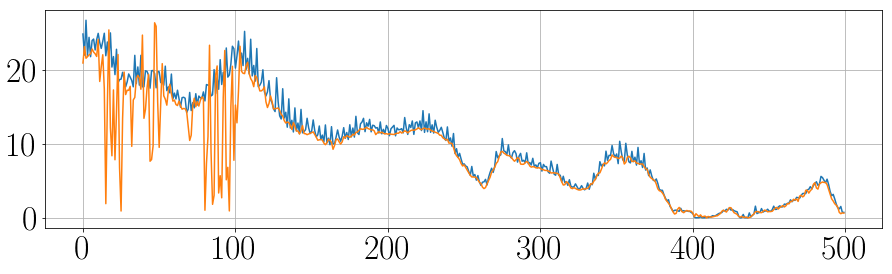

In [16]:
# Do interpolation (accumulatation for now)
interp_INS_speed = []
distance = 0
temp_speed = 0
j = 0
for i in range(len(RO_timestamps)):
    while(INS_timestamps[j] < RO_timestamps[i]):
        distance += INS_speeds[j]*(INS_timestamps[j]-INS_timestamps[j-1])
        j+=1
    temp_speed = distance/(RO_timestamps[i]-RO_timestamps[i-1])
    interp_INS_speed.append(temp_speed)
    distance = 0
plt.figure(figsize=(15,4))
plt.plot(interp_INS_speed[2000:2500])
plt.plot(RO_speeds[2000:2500])

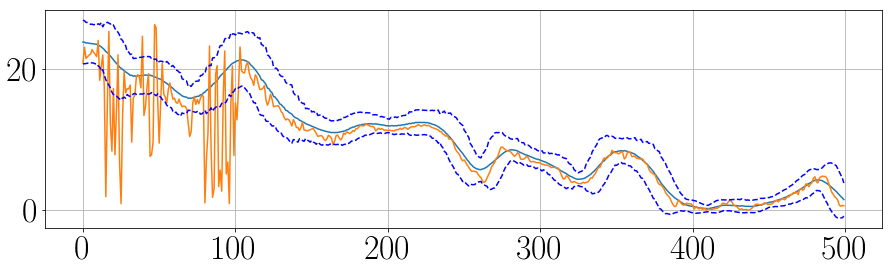

In [17]:
window_size = 20
std_devs = []
means = []
n_sigmas = 2
for i in range(window_size//2,len(interp_INS_speed)-window_size//2):
    window_contents = interp_INS_speed[i-window_size//2:i+window_size//2]
    std_devs.append(std(window_contents))
    means.append(mean(window_contents))
    
means = np.array(means)
means[-window_size//2:] = 0
means = np.roll(means,window_size//2)

std_devs = np.array(std_devs)
std_devs[-window_size//2:] = 0
std_devs = np.roll(std_devs,window_size//2)

plt.figure(figsize=(15,4))
plt.plot(means[2000:2500])
plt.plot(RO_speeds[2000:2500])
plt.plot(means[2000:2500]+n_sigmas*std_devs[2000:2500],'b--')
plt.plot(means[2000:2500]-n_sigmas*std_devs[2000:2500],'b--')
# plt.plot(means[2000:2500])
# plt.plot(RO_speeds[2005:2505])
# plt.plot(means[2000:2500]+n_sigmas*std_devs[2000:2500],'b--')
# plt.plot(means[2000:2500]-n_sigmas*std_devs[2000:2500],'b--')

In [18]:
# plt.figure(figsize=(30,8))
# plt.title('RO vs INS speeds with 2 std devs')
# plt.ylabel('Translational speeds (m/s)')
# plt.xlabel('Sample index')
# plt.plot(means)
# plt.plot(RO_speeds)
# plt.plot(means+n_sigmas*std_devs,'b--')
# plt.plot(means-n_sigmas*std_devs,'b--')
# # plt.plot(means+3*std_devs,'k--')
# # plt.plot(means-3*std_devs,'k--')
# plt.ylim(-5,100)

In [19]:
# Checking for failures based on speeds (not accelerations)
m = len(means)
upper_thresh = means + n_sigmas*std_devs
lower_thresh = means - n_sigmas*std_devs
minimum_speed_to_label = 0.5
label_reach_back = 0
classification = ones(m)*-1
for i in range(m):
    if(RO_speeds[i] < lower_thresh[i]) or RO_speeds[i] > upper_thresh[i]:
        if(means[i] > minimum_speed_to_label):
            classification[i-label_reach_back:i+1] = 1;
#     else:
#         classification[i+window_size//2,] = -1;

5936
5955
5954


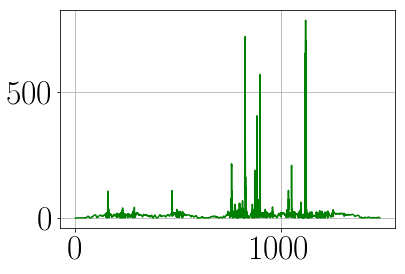

In [85]:
t_ro = np.array([x - RO_TIMESTAMPS[0] for x in RO_TIMESTAMPS])
t_ro = t_ro/1e6
t_ins = t_ro[:-19]
t_ero = t_ro[:-1]
plt.plot(t_ro,RO_speeds,'g-',markersize=0.5)
print(len(t_ins))
print(len(t_ro))
print(len(t_ero))

In [21]:
# Get error indices
labels = [] #zeros(len(EVec_timestamps))
for i in range(m):
    if(classification[i] == 1):
        labels.append(1)
    else:
        labels.append(-1)
print(size(labels))

5936


Detected failures: 1265 of 5936 samples


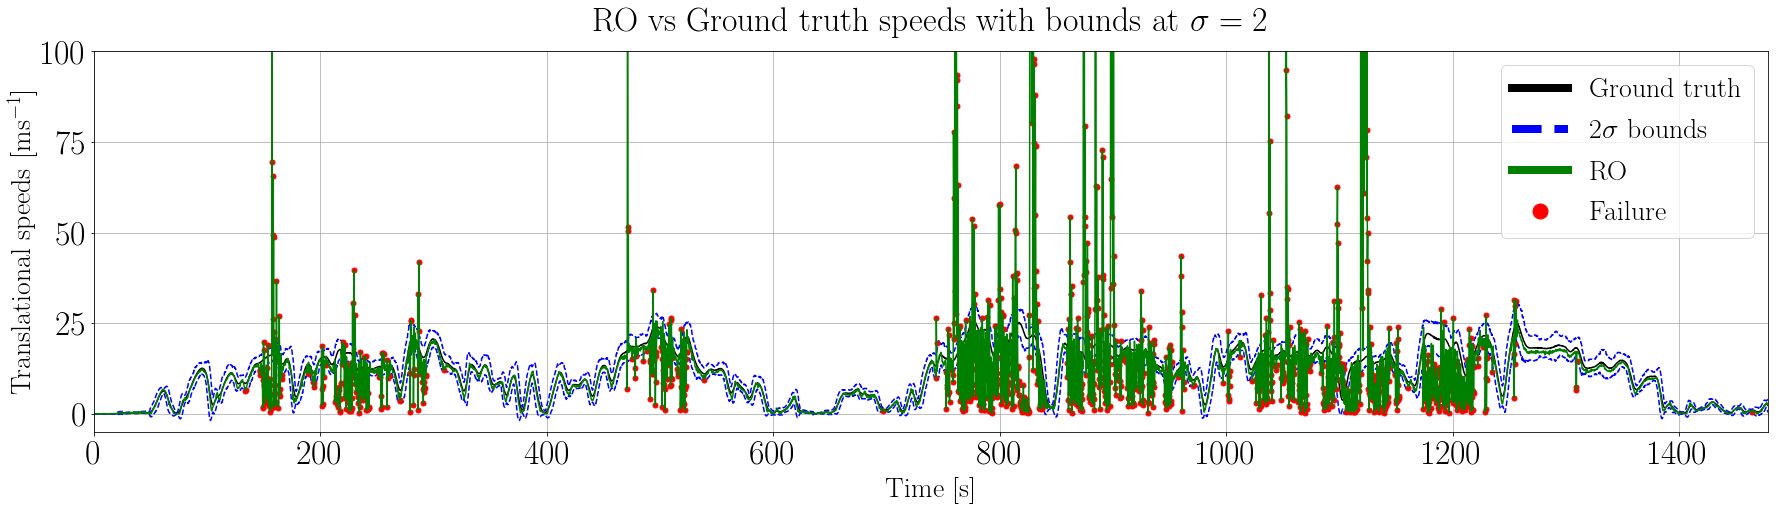

In [22]:
x_start = 0
x_finish = len(means)
plt.figure(figsize=(30,7))
plt.title('RO vs Ground truth speeds with bounds at $\sigma = 2$')
plt.ylabel('Translational speeds [ms$^{-1}]$')
plt.xlabel('Time [s]')
plt.plot(t_ins,means,'k')
plt.plot(t_ins,means+n_sigmas*std_devs,'b--')
plt.plot(t_ins,means-n_sigmas*std_devs,'b--')
for i in range(m):
    if(classification[i] == 1):
        plt.plot(t_ro[i],RO_speeds[i],'r.-',markersize=10)
#     else:
plt.plot(t_ro,RO_speeds,'g-',markersize=0.5) 
plt.ylim(-5,100)
plt.xlim(0,t_ins[-1])

line1, = plt.plot([],[],color='black',label='Ground truth',linewidth=8.0)
line2, = plt.plot([],[],'b--',label='2$\sigma$ bounds',linewidth=8.0)
line3, = plt.plot([],[],color='green',label='RO',linewidth=8.0)
line4, = plt.plot([],[],'r.',label='Failure',markersize=30)
plt.legend(handles=[line1,line2,line3,line4])

tally = np.count_nonzero(classification==1);

print('Detected failures:',tally,"of",m,'samples')
plt.savefig(dataset_path+"figs/filename_ro_translational_speeds.pdf",bbox_inches = 'tight',
    pad_inches = 0)

Detected failures: 905 of 5936 samples


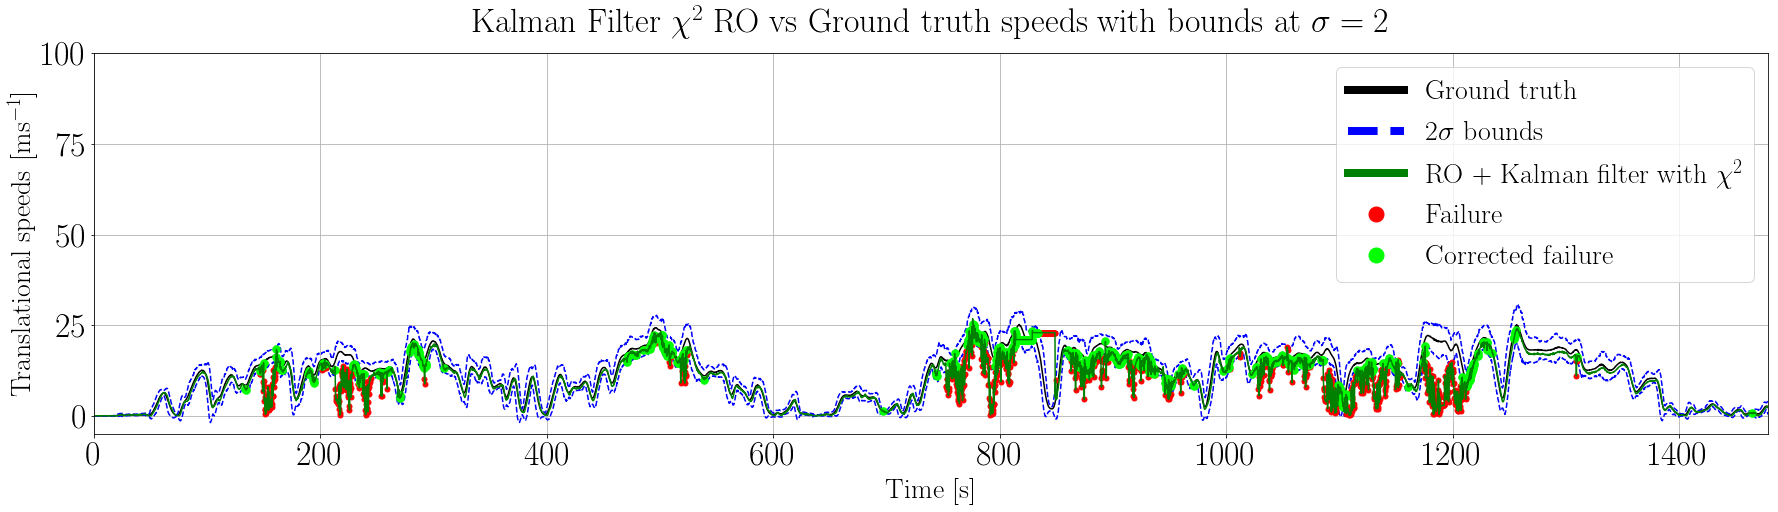

In [23]:
# KFC RO
plt.figure(figsize=(30,7))
plt.title('Kalman Filter $\chi^2$ RO vs Ground truth speeds with bounds at $\sigma = 2$')
plt.ylabel('Translational speeds [ms$^{-1}]$')
plt.xlabel('Time [s]')
plt.plot(t_ins,means,'k')
plt.plot(t_ins,means+n_sigmas*std_devs,'b--')
plt.plot(t_ins,means-n_sigmas*std_devs,'b--')

KFC_classification = ones(m)*-1
for i in range(m-1):
    if(KFC_speeds[i] < lower_thresh[i]) or KFC_speeds[i] > upper_thresh[i] and KFC_speeds[i] > minimum_speed_to_label:
        KFC_classification[i] = 1;

for i in range(m):
    if(KFC_classification[i] == 1):
        plt.plot(t_ro[i],KFC_speeds[i],'r.-',markersize=10)
for i in range(m):
    if(classification[i] == 1 and KFC_classification[i] == -1):
        plt.plot(t_ro[i],KFC_speeds[i],'.-',color=[0,1,0],markersize=15)
plt.plot(t_ro,KFC_speeds,'g-',markersize=0.5) 
plt.ylim(-5,100)    
plt.xlim(0,t_ins[-1])

line1, = plt.plot([],[],color='black',label='Ground truth',linewidth=8.0)
line2, = plt.plot([],[],'b--',label='2$\sigma$ bounds',linewidth=8.0)
line3, = plt.plot([],[],color='green',label='RO + Kalman filter with $\chi^2$',linewidth=8.0)
line4, = plt.plot([],[],'r.',label='Failure',markersize=30)
line5, = plt.plot([],[],'.',color=[0,1,0],label='Corrected failure',markersize=30)
plt.legend(handles=[line1,line2,line3,line4,line5])

tally = np.count_nonzero(KFC_classification==1);

print('Detected failures:',tally,"of",m,'samples')
plt.savefig(dataset_path+"figs/filename_kfc_translational_speeds.pdf",bbox_inches='tight',pad_inches = 0)

IndexError: list index out of range

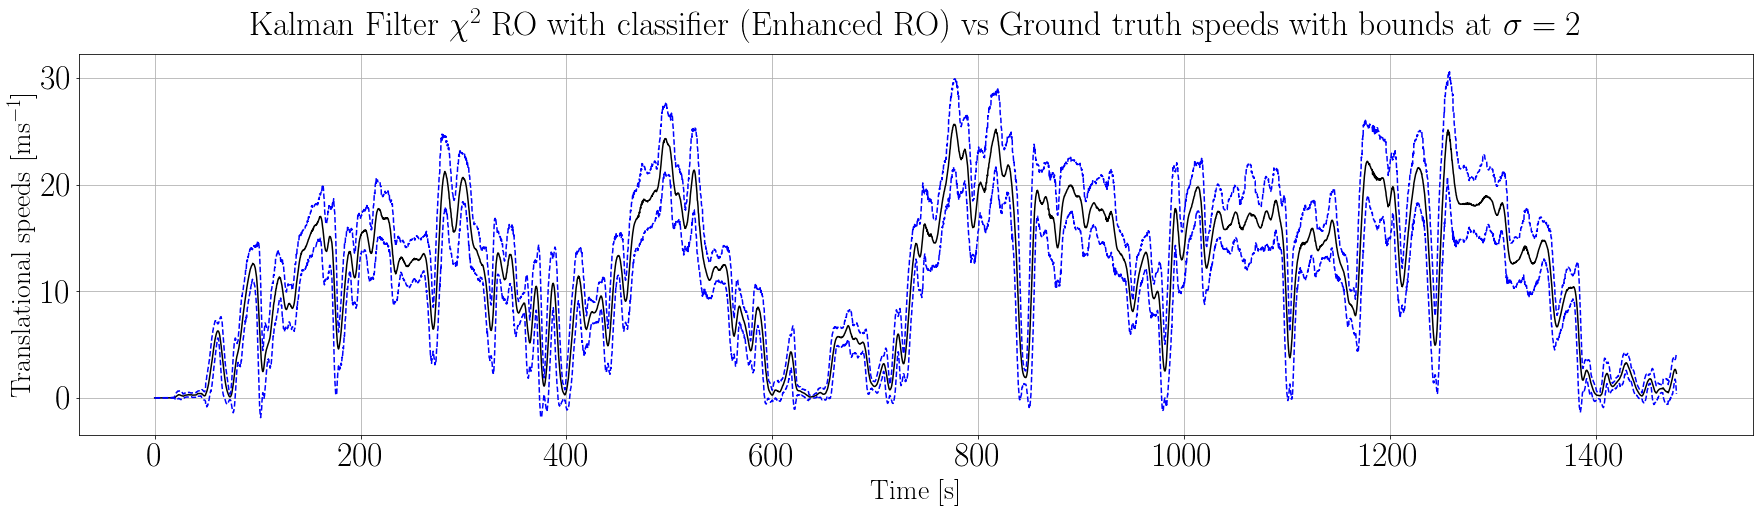

In [186]:
# Enhanced RO
plt.figure(figsize=(30,7))
plt.title('Kalman Filter $\chi^2$ RO with classifier (Enhanced RO) vs Ground truth speeds with bounds at $\sigma = 2$')
plt.ylabel('Translational speeds [ms$^{-1}]$')
plt.xlabel('Time [s]')
plt.plot(t_ins,means,'k')
plt.plot(t_ins,means+n_sigmas*std_devs,'b--')
plt.plot(t_ins,means-n_sigmas*std_devs,'b--')

# m = len(ERO_TIMESTAMPS)
ERO_classification = ones(m)*-1
for i in range(m-1):
    if(ERO_speeds[i] < lower_thresh[i]) or ERO_speeds[i] > upper_thresh[i] and ERO_speeds[i] > minimum_speed_to_label:
        ERO_classification[i] = 1;

for i in range(m):
    if(ERO_classification[i] == 1):
        plt.plot(t_ero[i],ERO_speeds[i],'r.-',markersize=10)
for i in range(m):
    if(classification[i] == 1 and ERO_classification[i] == -1):
        plt.plot(t_ero[i],ERO_speeds[i],'.-',color=[0,1,0],markersize=15)
    if(KFC_classification[i] == 1 and ERO_classification[i] == -1):
        plt.plot(t_ero[i],ERO_speeds[i],'.-',color='magenta',markersize=15)
    if(ERO_classification[i] == 1 and KFC_classification[i] == -1):
        plt.plot(t_ero[i],ERO_speeds[i],'*-',color='black',markersize=15)
plt.plot(t_ero[0:5953],ERO_speeds,'g-',markersize=0.5) 
# plt.plot(t_ero,ERO_speeds,'g-',markersize=0.5) 
plt.ylim(-5,100)    
plt.xlim(0,t_ins[-1])
# plt.xlim([700,1000])
line1, = plt.plot([],[],color='black',label='Ground truth',linewidth=8.0)
line2, = plt.plot([],[],'b--',label='2$\sigma$ bounds',linewidth=8.0)
line3, = plt.plot([],[],color='green',label='Enhanced RO',linewidth=8.0)
line4, = plt.plot([],[],'r.',label='Failure',markersize=30)
line5, = plt.plot([],[],'.',color=[0,1,0],label='Corrected failure',markersize=30)
plt.legend(handles=[line1,line2,line3,line4,line5])

tally = np.count_nonzero(ERO_classification==1);

print('Detected failures:',tally,"of",m,'samples')
plt.savefig(dataset_path+"figs/filename_ero_translational_speeds.pdf",bbox_inches='tight',pad_inches = 0)

In [179]:
tmp_labels = np.array(labels) + 1
indices = np.where(tmp_labels) # get indices of failures
tmp_ro_speeds = np.array(RO_speeds)
ro_fail_vals = abs(means[indices] - tmp_ro_speeds[indices]) - n_sigmas*std_devs[indices]
print('Size of RO fails:',len(ro_fail_vals))

tmp_labels = np.array(KFC_classification) + 1
indices = np.where(tmp_labels) # get indices of failures
tmp_kfc_speeds = np.array(KFC_speeds)
kfc_fail_vals = abs(means[indices] - tmp_kfc_speeds[indices])- n_sigmas*std_devs[indices]
print('Size of KFC fails:',len(kfc_fail_vals))

tmp_labels = np.array(ERO_classification) + 1
indices = np.where(tmp_labels) # get indices of failures
tmp_ero_speeds = np.array(ERO_speeds)
ero_fail_vals = abs(means[indices] - tmp_ero_speeds[indices])- n_sigmas*std_devs[indices]
print('Size of ERO fails:',len(ero_fail_vals))

Size of RO fails: 1265
Size of KFC fails: 905
Size of ERO fails: 866


In [180]:
print('Means [RO, KFC, ERO]:',
      mean(ro_fail_vals),
      mean(kfc_fail_vals),
      mean(ero_fail_vals))
print('Stds [RO, KFC, ERO]:',
     std(ro_fail_vals),
     std(kfc_fail_vals),
     std(ero_fail_vals))

Means [RO, KFC, ERO]: 19.326687867106216 5.436530857174727 5.102790836754706
Stds [RO, KFC, ERO]: 65.8062908149039 4.853187811927801 4.386735126952426


Text(0.5,0,'Error in translational speed [ms$^{-1}]$')

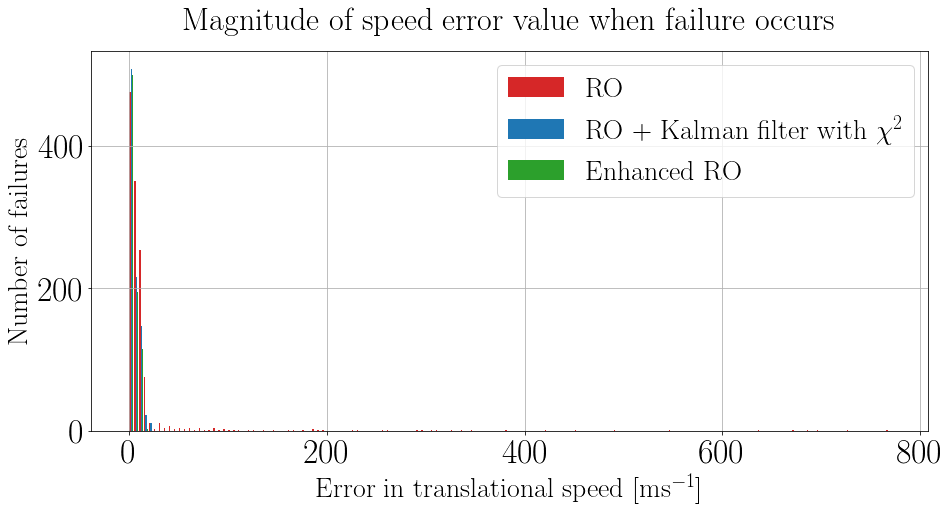

In [162]:
plt.figure(figsize=(15,7))
binwidth = 5
data_to_plot = [ro_fail_vals,kfc_fail_vals,ero_fail_vals]
n,bins,_ = plt.hist(data_to_plot,bins=np.arange(0, max(ro_fail_vals) + binwidth, binwidth),density=False,
# n,bins,_ = plt.hist(data_to_plot,bins=np.arange(0, 70, 0.1),density=False,
         color=[color_ro,color_kfc,color_ero],
         label=['RO','RO + Kalman filter with $\chi^2$','Enhanced RO']);
plt.legend(loc='upper right')
plt.title('Magnitude of speed error value when failure occurs',fontsize=32,pad=20)
plt.ylabel('Number of failures')
plt.xlabel('Error in translational speed [ms$^{-1}]$')
# plt.savefig(dataset_path+"figs/filename_error_histogram.pdf",bbox_inches='tight',pad_inches = 0)

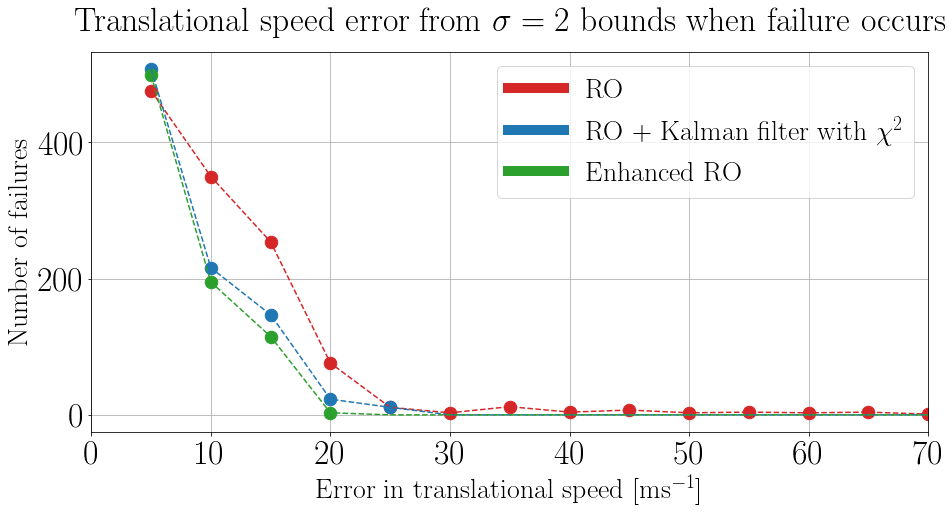

In [163]:
plt.figure(figsize=(15,7))
for i in range(len(n[0])):
    if(n[0][i] > 0):
        plt.plot(bins[i+1],n[0][i],'.-',color=color_ro,markersize=25);
    if(n[1][i] > 0):
        plt.plot(bins[i+1],n[1][i],'.-',color=color_kfc,markersize=25);
    if(n[2][i] > 0):
        plt.plot(bins[i+1],n[2][i],'.-',color=color_ero,markersize=25);
plt.plot(bins[1:],n[0],'--',color=color_ro);
plt.plot(bins[1:],n[1],'--',color=color_kfc);
plt.plot(bins[1:],n[2],'--',color=color_ero);
plt.title('Translational speed error from $\sigma=2$ bounds when failure occurs')
plt.ylabel('Number of failures')
plt.xlabel('Error in translational speed [ms$^{-1}]$')
line1, = plt.plot([],[],color=color_ro,label='RO',linewidth=10.0)
line3, = plt.plot([],[],color=color_kfc,label='RO + Kalman filter with $\chi^2$',linewidth=10.0)
line4, = plt.plot([],[],color=color_ero,label='Enhanced RO',linewidth=10.0)
plt.legend(handles=[line1,line3,line4],loc='best')
plt.xlim([0,70])
plt.savefig(dataset_path+"figs/filename_error_counts.pdf",bbox_inches='tight',pad_inches = 0)

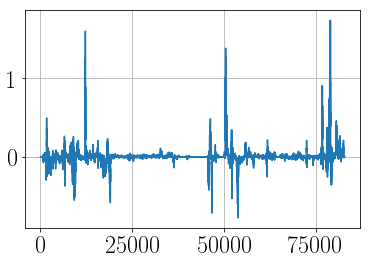

In [300]:
# INS yaw rates
assert len(INS_se3s) == len(INS_timestamps)
INS_yaw_rates = []
INS_TIMESTAMPS = []
for i in range(len(INS_timestamps) - 1):
    # work out yaw_rate
    delta_time = INS_timestamps[i + 1] / settings.TIMESTAMP_CONVERSION  \
        - INS_timestamps[i] / settings.TIMESTAMP_CONVERSION
    se3 = INS_se3s[i]
    xyzrpy = se3_to_components(se3)
    yaw_rate = xyzrpy[-1] / delta_time
    INS_yaw_rates.append(yaw_rate)
    INS_TIMESTAMPS.append(INS_timestamps[i])
plt.plot(INS_yaw_rates)

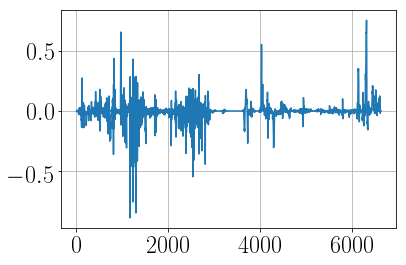

In [301]:
# RO yaw rates
assert len(RO_se3s) == len(RO_timestamps)
RO_yaw_rates = []
RO_TIMESTAMPS = []
for i in range(len(RO_timestamps) - 1):
    # work out yaw_rate
    delta_time = RO_timestamps[i + 1] / settings.TIMESTAMP_CONVERSION  \
        - RO_timestamps[i] / settings.TIMESTAMP_CONVERSION
    se3 = RO_se3s[i]
    xyzrpy = se3_to_components(se3)
    yaw_rate = xyzrpy[-1] / delta_time
    RO_yaw_rates.append(yaw_rate)
    RO_TIMESTAMPS.append(RO_timestamps[i])
plt.plot(RO_yaw_rates)

/Users/roberto/code/virtual-environments/ml-env-0/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


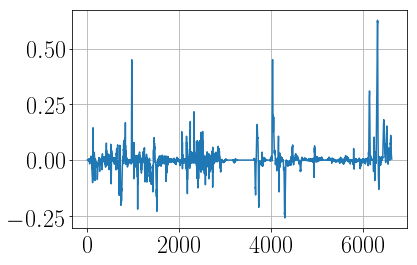

In [332]:
# KFC yaw rates
assert len(KFC_se3s) == len(KFC_timestamps)
KFC_yaw_rates = []
KFC_TIMESTAMPS = []
for i in range(len(KFC_timestamps) - 1):
    # work out yaw_rate
    delta_time = KFC_timestamps[i + 1] / settings.TIMESTAMP_CONVERSION  \
        - KFC_timestamps[i] / settings.TIMESTAMP_CONVERSION
    se3 = KFC_se3s[i]
    xyzrpy = se3_to_components(se3)
    yaw_rate = xyzrpy[-1] / delta_time
    KFC_yaw_rates.append(yaw_rate)
    KFC_TIMESTAMPS.append(KFC_timestamps[i])
plt.plot(KFC_yaw_rates)

/Users/roberto/code/virtual-environments/ml-env-0/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


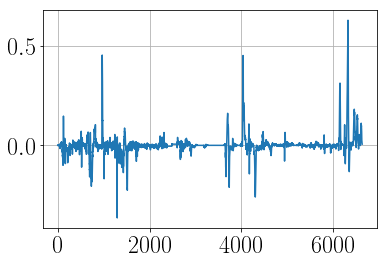

In [302]:
# ERO yaw rates
assert len(ERO_se3s) == len(ERO_timestamps)
ERO_yaw_rates = []
ERO_TIMESTAMPS = []
for i in range(len(ERO_timestamps) - 1):
    # work out yaw_rate
    delta_time = ERO_timestamps[i + 1] / settings.TIMESTAMP_CONVERSION  \
        - ERO_timestamps[i] / settings.TIMESTAMP_CONVERSION
    se3 = ERO_se3s[i]
    xyzrpy = se3_to_components(se3)
    yaw_rate = xyzrpy[-1] / delta_time
    ERO_yaw_rates.append(yaw_rate)
    ERO_TIMESTAMPS.append(ERO_timestamps[i])
plt.plot(ERO_yaw_rates)

(-2, 2)

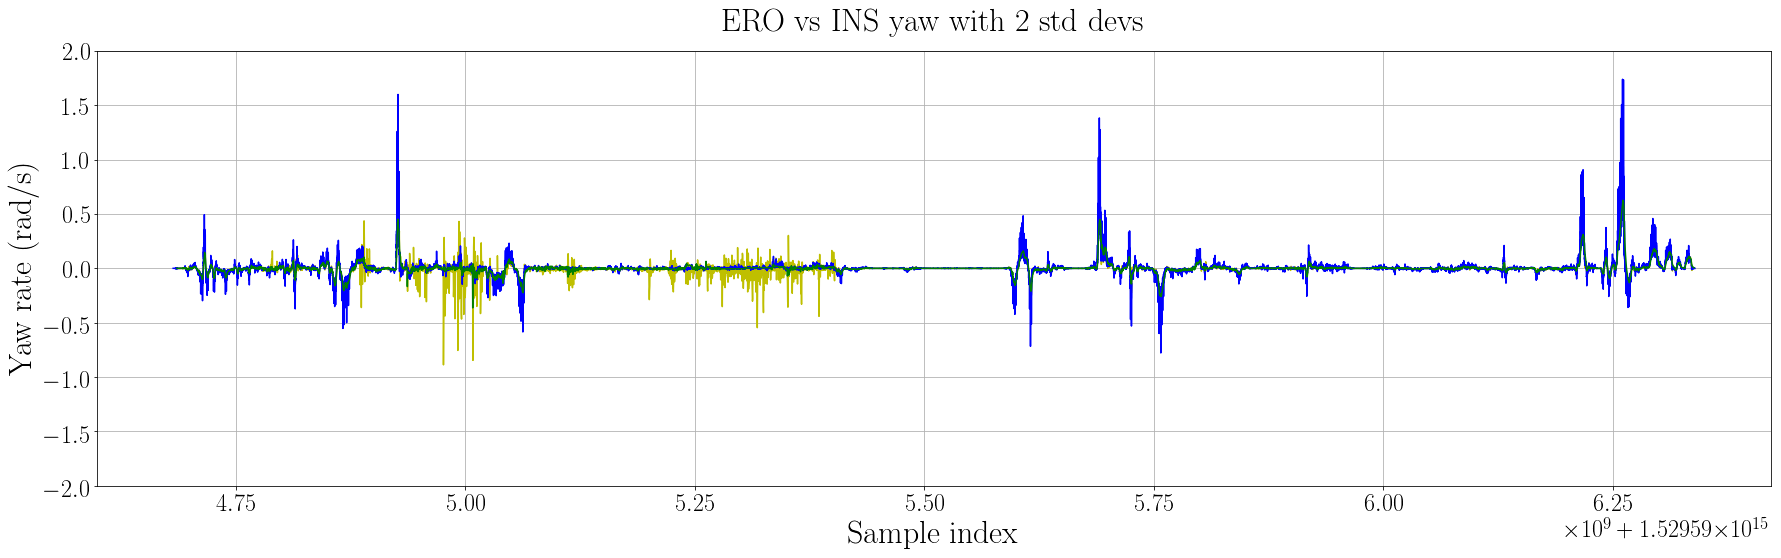

In [303]:
plt.figure(figsize=(30,8))
plt.title('ERO vs INS yaw with 2 std devs')
plt.ylabel('Yaw rate (rad/s)')
plt.xlabel('Sample index')
plt.plot(RO_TIMESTAMPS,RO_yaw_rates,'y',markersize=0.1)
plt.plot(INS_TIMESTAMPS,INS_yaw_rates,'b')
# for i in range(m):
#     if(ERO_classification[i] == 1):
#         plt.plot(i,ERO_yaw_rates[i],'r.-',markersize=10)
plt.plot(ERO_TIMESTAMPS,ERO_yaw_rates,'g')
plt.ylim(-2,2)

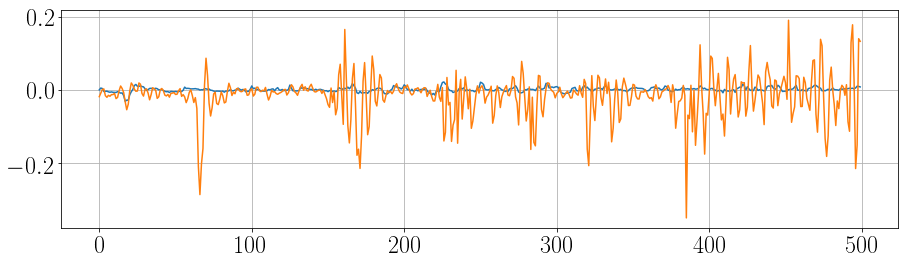

In [304]:
# Failures due to yaw rate
interp_INS_yaw = []
angle = 0
temp_angle = 0
j = 0
for i in range(len(RO_timestamps)):
    while(INS_timestamps[j] < RO_timestamps[i]):
        angle += INS_yaw_rates[j]*(INS_timestamps[j]-INS_timestamps[j-1])
        j+=1
    temp_angle = angle/(RO_timestamps[i]-RO_timestamps[i-1])
    interp_INS_yaw.append(temp_angle)
    angle = 0
plt.figure(figsize=(15,4))
plt.plot(interp_INS_yaw[2000:2500])
plt.plot(RO_yaw_rates[2000:2500])

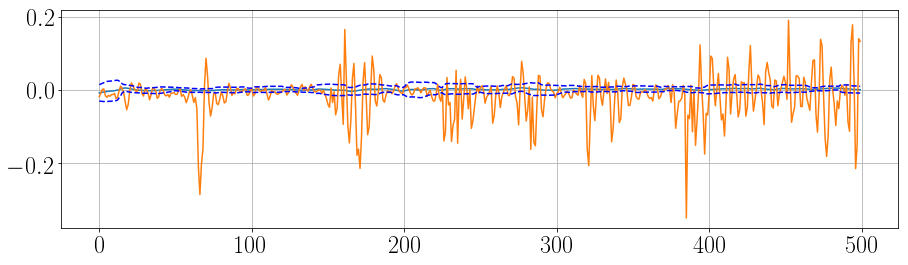

In [309]:
window_size = 20
yaw_std_devs = []
yaw_means = []
for i in range(window_size//2,len(interp_INS_yaw)-window_size//2):
    window_contents = interp_INS_yaw[i-window_size//2:i+window_size//2]
    yaw_std_devs.append(std(window_contents))
    yaw_means.append(mean(window_contents))
    
yaw_means = np.array(yaw_means)
yaw_std_devs = np.array(yaw_std_devs)
plt.figure(figsize=(15,4))
plt.plot(yaw_means[2005:2505])
plt.plot(RO_yaw_rates[2000:2500])
plt.plot(yaw_means[2005:2505]+n_sigmas*yaw_std_devs[2005:2505],'b--')
plt.plot(yaw_means[2005:2505]-n_sigmas*yaw_std_devs[2005:2505],'b--')

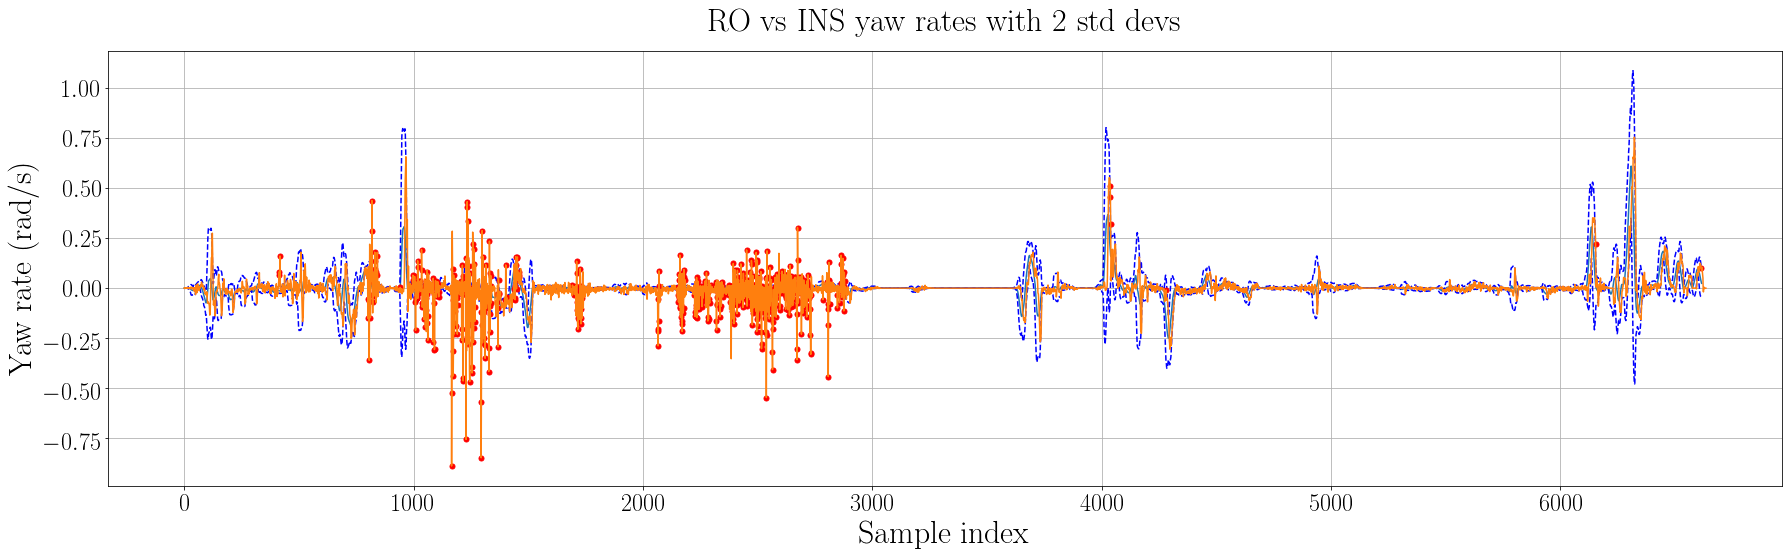

In [317]:
# Checking for failures based on yaw rates
m = len(yaw_means)
# max_tolerance = 0.2
yaw_upper_thresh = yaw_means + n_sigmas*yaw_std_devs
yaw_lower_thresh = yaw_means - n_sigmas*yaw_std_devs
# yaw_classification = zeros(m)
# for i in range(m):
#     if(RO_yaw_rates[i] < yaw_lower_thresh[i]) or RO_yaw_rates[i] > yaw_upper_thresh[i]:
#         yaw_classification[i] = 1;

plt.figure(figsize=(30,8))
plt.title('RO vs INS yaw rates with 2 std devs')
plt.ylabel('Yaw rate (rad/s)')
plt.xlabel('Sample index')
plt.plot(yaw_means)
plt.plot(yaw_means+n_sigmas*yaw_std_devs,'b--')
plt.plot(yaw_means-n_sigmas*yaw_std_devs,'b--')
for i in range(m):
    if(classification[i] == 1):
        plt.plot(i,RO_yaw_rates[i],'r.-',markersize=10)
plt.plot(RO_yaw_rates)

In [333]:
tmp_labels = np.array(labels) + 1
indices = np.where(tmp_labels) # get indices of failures
tmp_ro_yaw = np.array(RO_yaw_rates)
ro_fail_vals_yaw = abs(yaw_means[indices] - tmp_ro_yaw[indices]) - n_sigmas*yaw_std_devs[indices]
print('Size of RO fails:',len(ro_fail_vals_yaw))

tmp_labels = np.array(KFC_classification) + 1
indices = np.where(tmp_labels) # get indices of failures
tmp_kfc_yaw = np.array(KFC_yaw_rates)
kfc_fail_vals_yaw = abs(yaw_means[indices] - tmp_kfc_yaw[indices]) - n_sigmas*yaw_std_devs[indices]
print('Size of KFC fails:',len(kfc_fail_vals_yaw))

tmp_labels = np.array(ERO_classification) + 1
indices = np.where(tmp_labels) # get indices of failures
tmp_ero_yaw = np.array(ERO_yaw_rates)
ero_fail_vals_yaw = abs(yaw_means[indices] - tmp_ero_yaw[indices]) - n_sigmas*yaw_std_devs[indices]
print('Size of ERO fails:',len(ero_fail_vals_yaw))

Size of RO fails: 695
Size of KF fails: 560
Size of KFC fails: 442
Size of ERO fails: 109


In [336]:
print('Means:',
      mean(ro_fail_vals_yaw)*(180/pi),
      mean(kfc_fail_vals_yaw)*(180/pi),
      mean(ero_fail_vals_yaw)*(180/pi))
print('Stds:',
      std(ro_fail_vals_yaw)*(180/pi),
      std(kfc_fail_vals_yaw)*(180/pi),
      std(ero_fail_vals_yaw)*(180/pi))

Means: 3.874698710749278 0.6119220875657562 0.9770267847599715 -0.10509686920016427
Stds: 5.733963902104135 1.7676655698428791 1.9415559548434413 1.9270265113931353


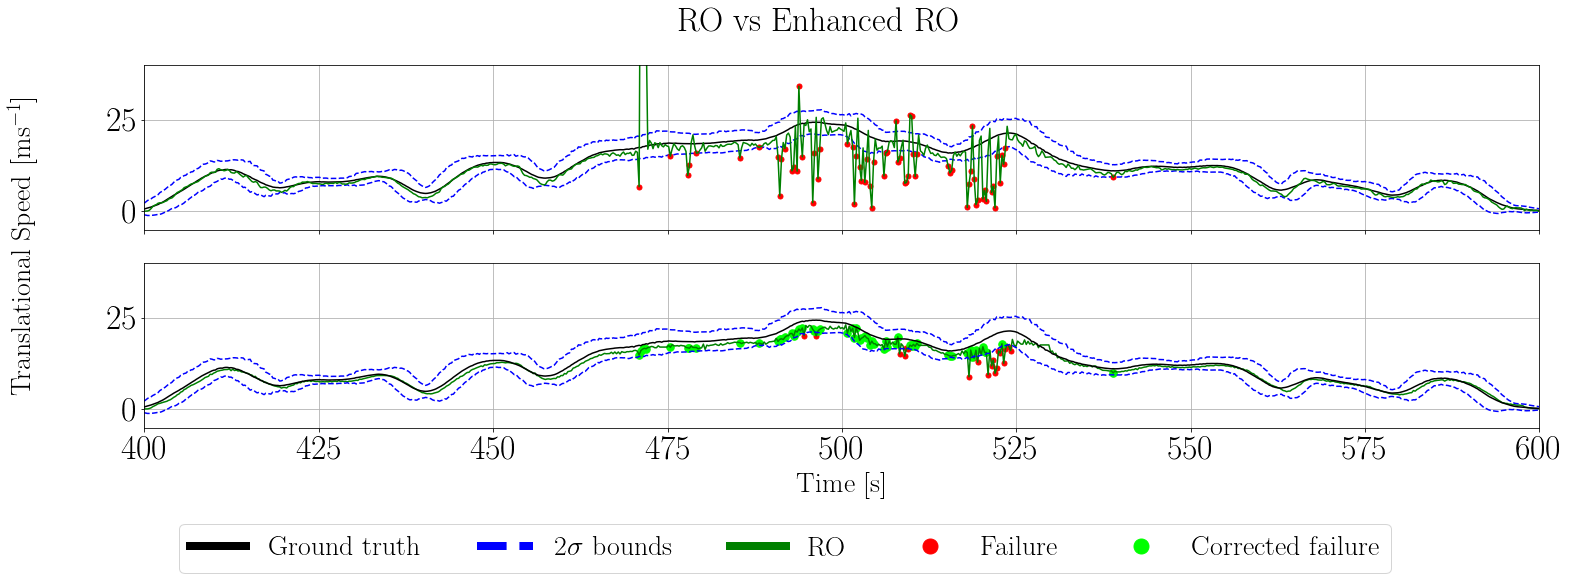

In [126]:
# Enhanced RO for Fig 1
f, axarr = plt.subplots(2, sharex=True,sharey=True,figsize=(25,8))
# add a big axes, hide frame
f.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel('Time [s]')
plt.ylabel('Translational Speed [ms$^{-1}$]')
f.suptitle('RO vs Enhanced RO')

axarr[0].plot(t_ins,means,'k')
axarr[0].plot(t_ins,means+n_sigmas*std_devs,'b--')
axarr[0].plot(t_ins,means-n_sigmas*std_devs,'b--')

for i in range(m):
    if(classification[i] == 1):
        axarr[0].plot(t_ro[i],RO_speeds[i],'r.-',markersize=10)
axarr[0].plot(t_ro,RO_speeds,'g-',markersize=0.5) 

axarr[0].set_ylim([-5,40])    
# # plt.xlim(0,t_ins[-1])
# axarr[0].set_xlim([460,750])
axarr[0].set_xlim([400,600])


ERO_classification = ones(m)*-1
for i in range(m-1):
    if(ERO_speeds[i] < lower_thresh[i]) or ERO_speeds[i] > upper_thresh[i] and ERO_speeds[i] > minimum_speed_to_label:
        ERO_classification[i] = 1;

for i in range(m):
    if(ERO_classification[i] == 1):
        axarr[1].plot(t_ero[i],ERO_speeds[i],'r.-',markersize=10)
for i in range(m):
    if(classification[i] == 1 and ERO_classification[i] == -1):
        axarr[1].plot(t_ero[i],ERO_speeds[i],'.-',color=[0,1,0],markersize=15)
axarr[1].plot(t_ero[0:-1],ERO_speeds,'g-',markersize=0.5) 
axarr[1].plot(t_ins,means,'k')
axarr[1].plot(t_ins,means+n_sigmas*std_devs,'b--')
axarr[1].plot(t_ins,means-n_sigmas*std_devs,'b--')

# f.subplots_adjust(right=0.8)
# f.subplots_adjust(top = 0.8)
f.subplots_adjust(bottom = 0.25)


# Put a legend to the right of the current axis
line1, = plt.plot([],[],color='black',label='Ground truth',linewidth=8.0)
line2, = plt.plot([],[],'b--',label='2$\sigma$ bounds',linewidth=8.0)
line3, = plt.plot([],[],color='green',label='RO',linewidth=8.0)
line4, = plt.plot([],[],'r.',label='Failure',markersize=30)
line5, = plt.plot([],[],'.',color=[0,1,0],label='Corrected failure',markersize=30)
# f.legend(loc='center right',handles=[line1,line2,line3,line4,line5],borderaxespad=0.1)
f.legend(loc='lower center',handles=[line1,line2,line3,line4,line5],borderaxespad=0.1,ncol=5)


f.savefig(dataset_path+"figs/filename_section_ero_translational_speeds.pdf",bbox_inches='tight',pad_inches = 0)

In [94]:
count_nonzero(ERO_classification[3100:3300]==1)

128

In [127]:
count_nonzero(KFC_classification[3100:3300]==1)

110

1038
410
531


/Users/roberto/code/virtual-environments/ml-env-0/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
/Users/roberto/code/virtual-environments/ml-env-0/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


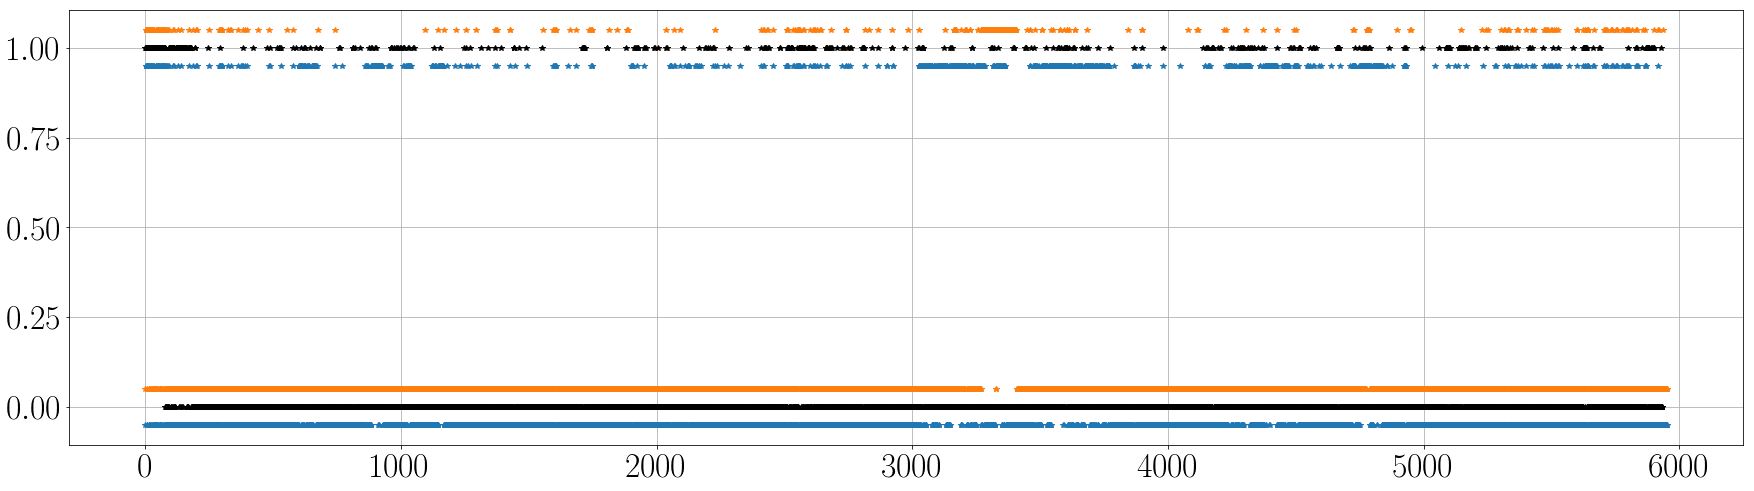

In [155]:
tmpdiff_ero = np.abs(np.diff(ERO_speeds)) < 1e-2
tmpdiff_kfc = np.abs(np.diff(KFC_speeds)) < 1e-2
tmpdiff_means = np.abs(np.diff(means)) < 1e-2


print(count_nonzero(tmpdiff_ero))
print(count_nonzero(tmpdiff_kfc))
print(count_nonzero(tmpdiff_means))

plt.figure(figsize=(30,8))
plt.plot(tmpdiff_ero-0.05,'*')
plt.plot(tmpdiff_kfc+0.05,'*')
plt.plot(tmpdiff_means,'k*')

In [167]:
dateAndTime = '2019-04-11-15-08-51'
filename = "/Users/roberto/data/odometry-comparisons/rugged_ro/"\
"2018-06-21-15-58-58-rural-loop-v4-radar-leopon-trial-sunny-long-range/"\
"motion_estimation/untuned-kalman-with-chi-KFC-SVM-0.6thresh-median-labels-with-logging/"\
+dateAndTime+'/SVM_chi_vals.csv';

print('Reading from: ' + filename)
df_SVM_chi_vals = pd.read_csv(filename, names=range(3))

Reading from: /Users/roberto/data/odometry-comparisons/rugged_ro/2018-06-21-15-58-58-rural-loop-v4-radar-leopon-trial-sunny-long-range/motion_estimation/untuned-kalman-with-chi-KFC-SVM-0.6thresh-median-labels-with-logging/2019-04-11-15-08-51/SVM_chi_vals.csv


In [174]:
tmp_data = np.array(df_combined_data)
tal = np.logical_and(tmp_data[:,0], tmp_data[:,2])
print('SVM 1s',count_nonzero(tmp_data[:,0]))
print('Chi 1s',count_nonzero(tmp_data[:,2]))
print('Both 1s',count_nonzero(tal))

SVM 1s 966
Chi 1s 237
Both 1s 138


(0, 2300)

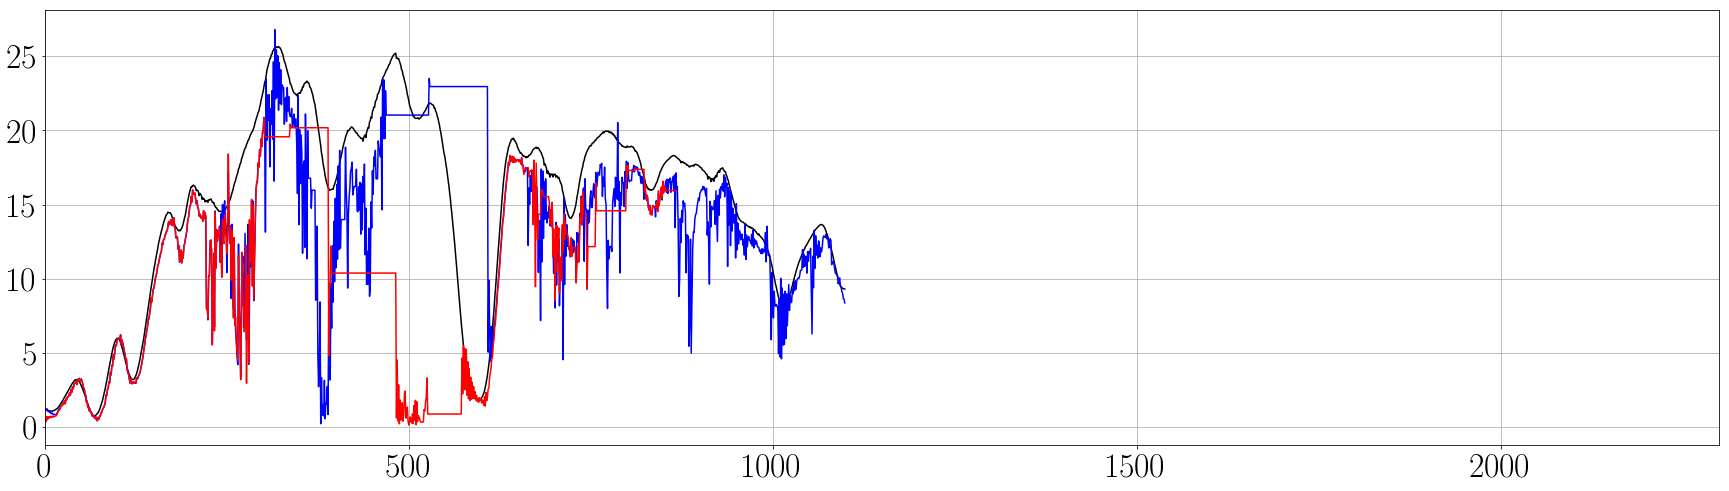

In [213]:
plt.figure(figsize=(30,8))
plt.plot(means[2800:3900],'k')
plt.plot(KFC_speeds[2800:3900],'b')
plt.plot(ERO_speeds,'r')
plt.xlim([0,2300])

In [193]:
idx = len(ERO_speeds)
ERO_classification = ones(idx)*-1
for i in range(idx-1):
    if(ERO_speeds[i] < lower_thresh[i]) or ERO_speeds[i] > upper_thresh[i] and ERO_speeds[i] > minimum_speed_to_label:
        ERO_classification[i] = 1;

In [200]:
count_nonzero(ERO_classification[0:1000] == 1)

171

In [199]:
count_nonzero(KFC_classification[0:1000] == 1)

150